In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os


folder_path = '/content/drive/MyDrive/'

train_path = os.path.join(folder_path, 'train_data.csv')
test_path = os.path.join(folder_path, 'test_data.csv')

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    print(f"Train size: {train_df.shape}")
    print(train_df.head(3))
except FileNotFoundError:
    print("Error: Files nahi mili! Ek baar left side folder icon mein ja kar check karein ki files ka sahi path kya hai.")

Train size: (1523975, 2)
                                            sentence  sentiment
0  awww that s a bummer you shoulda got david car...          0
1  is upset that he can t update his facebook by ...          0
2  i dived many times for the ball managed to sav...          0


In [4]:
import re


print("Null values in Train:", train_df.isnull().sum())

train_df = train_df.dropna()
test_df = test_df.dropna()


def simple_cleaner(text):

    text = re.sub(r'[^a-z\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text



train_df['sentence'] = train_df['sentence'].apply(simple_cleaner)
test_df['sentence'] = test_df['sentence'].apply(simple_cleaner)

print("Cleaning Complete!")
print(train_df.head())

Null values in Train: sentence     0
sentiment    0
dtype: int64
Cleaning Complete!
                                            sentence  sentiment
0  awww that s a bummer you shoulda got david car...          0
1  is upset that he can t update his facebook by ...          0
2  i dived many times for the ball managed to sav...          0
3     my whole body feels itchy and like its on fire          0
4  no it s not behaving at all i m mad why am i h...          0


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

tweet_lengths = train_df['sentence'].apply(lambda x: len(str(x).split()))
max_len_real = int(tweet_lengths.quantile(0.95))


max_words_real = 30000

print(f"Data Analysis: Max Length (95th percentile) = {max_len_real}")
print(f"Vocab Size = {max_words_real}")


vectorize_layer = TextVectorization(
    max_tokens=max_words_real,
    output_mode='int',
    output_sequence_length=max_len_real
)

print("Vocabulary par 'Adapt' ho raha hai... thoda time lag sakta hai.")
vectorize_layer.adapt(train_df['sentence'].values)


X_train = vectorize_layer(train_df['sentence'].values)
X_test = vectorize_layer(test_df['sentence'].values)
y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

model = Sequential([

    Embedding(input_dim=max_words_real, output_dim=128, input_length=max_len_real),

    Bidirectional(LSTM(64)),


    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Data Analysis: Max Length (95th percentile) = 26
Vocab Size = 30000
Vocabulary par 'Adapt' ho raha hai... thoda time lag sakta hai.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]


history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
1489/1489 ━━━━━━━━━━━━━━━━━━━━ 797s 535ms/step - accuracy: 0.7950 - loss: 0.4440 - val_accuracy: 0.8329 - val_loss: 0.4001
Epoch 2/3
1489/1489 ━━━━━━━━━━━━━━━━━━━━ 797s 535ms/step - accuracy: 0.8270 - loss: 0.3853 - val_accuracy: 0.8301 - val_loss: 0.3815
Epoch 3/3
1489/1489 ━━━━━━━━━━━━━━━━━━━━ 786s 524ms/step - accuracy: 0.8403 - loss: 0.3594 - val_accuracy: 0.8329 - val_loss: 0.3717


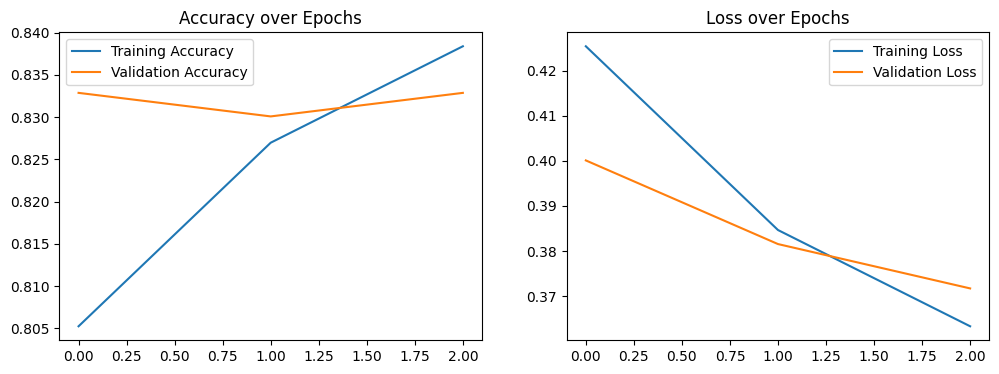

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

In [9]:
def predict_sentiment(tweet):

    cleaned_tweet = simple_cleaner(tweet.lower())

    vectorized_tweet = vectorize_layer([cleaned_tweet])


    prediction = model.predict(vectorized_tweet, verbose=0)[0][0]

    if prediction >= 0.5:
        return f"Positive 😊 (Score: {prediction:.2f})"
    else:
        return f"Negative ☹️ (Score: {prediction:.2f})"


print(predict_sentiment("I am so happy that my model is finally trained!"))
print(predict_sentiment("The training took a lot of time and I am tired."))

Positive 😊 (Score: 1.00)
Negative ☹️ (Score: 0.18)


In [10]:
import pickle


model.save('twitter_sentiment_model.h5')

vectorizer_data = {
    'config': vectorize_layer.get_config(),
    'weights': vectorize_layer.get_weights()
}

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer_data, f)



In [11]:
import pickle


model.save('twitter_sentiment_model.keras')


vectorizer_data = {
    'config': vectorize_layer.get_config(),
    'weights': vectorize_layer.get_weights()
}

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer_data, f)

